In [1]:
cd -q ~/TaskSCCA_craddock/

In [2]:
import matplotlib.pyplot as plt

import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from src.utils import unflatten, save_pkl, load_pkl, is_outliers, imputedata

from statsmodels.multivariate.manova import MANOVA
from scipy.stats import zscore

import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_style({"font.sans-serif": ["Arial"]})
sns.set_context('paper', font_scale=1.5)

In [3]:
from statsmodels.stats.multitest import multipletests

# Prepare data

In [4]:
X_clean = np.load('data/processed/X_clean.npy')
Y_clean = np.load('data/processed/Y_clean.npy')
sig_mod = load_pkl('models/sig_95th.pkl')
model = load_pkl('models/full_model_95th.pkl')

path_master = 'data/interim/df_master_p178.pkl'
df_master = pd.read_pickle(path_master)

df_es = pd.read_pickle('./data/interim/CS_MWQ_prepro.pkl')

sig = sig_mod['sig']


X_scores, Y_scores = model.transform(X_clean, Y_clean)
X_scores, Y_scores = X_scores[:, sig], Y_scores[:, sig]

cca_df = pd.DataFrame({'Functional connectivity 1': X_scores[:, 0], 
                       'Functional connectivity 2': X_scores[:, 1],
                       'Cognitive task 1': Y_scores[:, 0], 
                       'Cognitive task 2': Y_scores[:, 1],})

df_cca = pd.DataFrame(zscore(X_scores) + zscore(Y_scores), 
                      columns=['component_1', 'component_2'], 
                      index=df_master.index)

In [5]:
df_es = pd.read_pickle('./data/interim/CS_MWQ_prepro.pkl').infer_objects()
df_es_byday = df_es.pivot_table(index=['RIDNO', 'session'],
                                 values=df_es.columns[3:],
                                 aggfunc=np.mean).apply(zscore)
df_es_byday = df_es_byday.unstack()

In [6]:
# USE THIS FOR STATS IN THE NOTEBOOK
df_stats = pd.concat([df_es_byday, df_cca], axis=1, join='inner')

In [7]:
df_stats.columns

Index([('MWQ_Deliberate', 1.0), ('MWQ_Deliberate', 2.0),
       ('MWQ_Deliberate', 3.0),   ('MWQ_Detailed', 1.0),
         ('MWQ_Detailed', 2.0),   ('MWQ_Detailed', 3.0),
          ('MWQ_Emotion', 1.0),    ('MWQ_Emotion', 2.0),
          ('MWQ_Emotion', 3.0),   ('MWQ_Evolving', 1.0),
         ('MWQ_Evolving', 2.0),   ('MWQ_Evolving', 3.0),
            ('MWQ_Focus', 1.0),      ('MWQ_Focus', 2.0),
            ('MWQ_Focus', 3.0),     ('MWQ_Future', 1.0),
           ('MWQ_Future', 2.0),     ('MWQ_Future', 3.0),
            ('MWQ_Habit', 1.0),      ('MWQ_Habit', 2.0),
            ('MWQ_Habit', 3.0),     ('MWQ_Images', 1.0),
           ('MWQ_Images', 2.0),     ('MWQ_Images', 3.0),
            ('MWQ_Other', 1.0),      ('MWQ_Other', 2.0),
            ('MWQ_Other', 3.0),       ('MWQ_Past', 1.0),
             ('MWQ_Past', 2.0),       ('MWQ_Past', 3.0),
             ('MWQ_Self', 1.0),       ('MWQ_Self', 2.0),
             ('MWQ_Self', 3.0),      ('MWQ_Vivid', 1.0),
            ('MWQ_Vivid', 2.0),

In [8]:
dict_days = {'1': [], 
             '2': [], 
             '3': []
            }

lables_es = []
for c in df_es_byday.columns:
    dict_days[str(int(c[1]))].append(c)
    if c[1] == 1:
        lables_es.append(c[0])

In [9]:
def MANOVA_with_fig(df_stats, endog_labels):
    manova = MANOVA(endog=df_stats[endog_labels],
                exog=df_stats[['component_1', 'component_2']] )
    
    print(manova.mv_test())
    results = manova.mv_test().results
    sig_key = []

    for key, (_, output) in zip(manova.mv_test().exog_names, results.items()):
        p_val = output['stat']['Pr > F'][0]
        key = (' ').join(key.split('_'))
        if  p_val < 0.05:
            sig_key.append((key, p_val))
            
        # partial eta square
        f_val = output['stat']['F Value'][0]
        den_df = output['stat']['Den DF'][0]
        num_df = output['stat']['Num DF'][0]
        par_eta_sqr = num_df * f_val / (num_df *f_val + den_df)
        print('partical eta squared of {}: {}'.format(key, par_eta_sqr))
        
    if len(sig_key) == 0:
        sig_key.append(('None', 'N/A'))
    
    df_coef = pd.DataFrame()
    df_pval = pd.DataFrame()

    for q in endog_labels:
        univeriate = smf.ols(formula='{} ~ component_1 + component_2'.format(q), data=df_stats).fit()
        print(univeriate.summary())
        p_adjust = multipletests(univeriate.pvalues, alpha=0.05, method='bonferroni')
        df_coef = df_coef.append(univeriate.params, ignore_index=True)
        df_p_adjust = pd.DataFrame(np.array([p_adjust[0],
                                             p_adjust[1]]).T, 
                                   index=['Intercept', '1', '2'],
                                   columns=['Sig.', 'p_adjusted']
                                  )
        df_pval = df_pval.append(df_p_adjust.iloc[:, 1], ignore_index=True)
        print(df_p_adjust)
        print('Bonferroni corrected alpha (0.05): {}\n'.format(
            multipletests(univeriate.pvalues, alpha=0.05, method='bonferroni')[-1]))
    
    df_coef.index = [a.split('_')[-1] for a in lables_es]
    df_pval.index = df_coef.index

    df_coef.columns = ['Intercept', '1', '2']


    sns.heatmap(df_coef.iloc[:, 1:], cmap="PiYG_r", square=False, center=0, annot=df_pval.iloc[:, :-1])
    plt.title('Full univariate results')
    plt.annotate('''
    * Value in each cell is Bonferroni corrected p-value.
    ** {:} is significant at multivatiate level.
       p = {:}'''.format(sig_key[0][0], sig_key[0][1]), 
                 (0,0), (0, -30), 
                 xycoords='axes fraction', 
                 textcoords='offset points', va='top')
    plt.tight_layout()
#     plt.savefig(filename, dpi=300, transparent=True)
    return df_coef

# Predict thoguhts with CCA components

When using the two CCA scores to predict the expereince sampling questions scores, component 2 is significant in all the mutivariate models of all the questions, 0-back or 1-back questions. The difference score of 0-back and 1-back, however, didn't show significant relationships in the MANOVA. See bellow to find the detailed MANOVA tables and the correlation coefficients and Bonferroni adjusted p-values of the univariate model in heat map format.

When predicting PCA scores, there's no significant results at the multivariate level.

## MANOVA: overall

                  Multivariate linear model
                                                              
--------------------------------------------------------------
           x0           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9518 13.0000 164.0000  0.6390 0.8186
         Pillai's trace 0.0482 13.0000 164.0000  0.6390 0.8186
 Hotelling-Lawley trace 0.0506 13.0000 164.0000  0.6390 0.8186
    Roy's greatest root 0.0506 13.0000 164.0000  0.6390 0.8186
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
           x1           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.8147 13.0000 164.0000  2.8694 0.0009
         Pillai's trace 0.1853 13.0000 164.0000  2.8694 0.0009
 Hotelling-

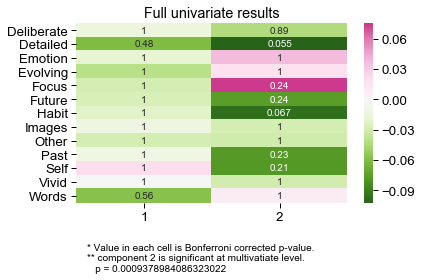

In [10]:
df_es_mean = df_es.pivot_table(index=['RIDNO'],
                               values=df_es.columns[3:],
                               aggfunc=np.mean).apply(zscore)
df_stats = pd.concat([df_es_mean, df_cca], axis=1, join='inner')
df_stats.columns = lables_es + ['component_1', 'component_2']
es_coef = MANOVA_with_fig(df_stats, lables_es)

## MANOVA: day 1

(178, 15)
                  Multivariate linear model
                                                              
--------------------------------------------------------------
           x0           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9360 13.0000 164.0000  0.8626 0.5936
         Pillai's trace 0.0640 13.0000 164.0000  0.8626 0.5936
 Hotelling-Lawley trace 0.0684 13.0000 164.0000  0.8626 0.5936
    Roy's greatest root 0.0684 13.0000 164.0000  0.8626 0.5936
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
           x1           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.8687 13.0000 164.0000  1.9061 0.0327
         Pillai's trace 0.1313 13.0000 164.0000  1.9061 0.0327
 

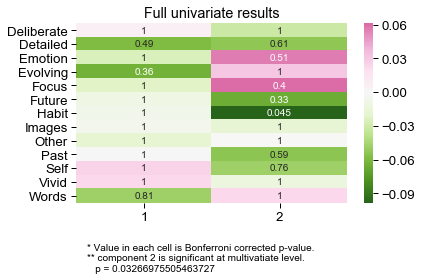

In [11]:
df_stats = pd.concat([df_es_byday[dict_days['1']], df_cca], axis=1, join='inner')
df_stats.columns = lables_es + ['component_1', 'component_2']
print(df_stats.shape)
es1_coef = MANOVA_with_fig(df_stats, lables_es)

## MANOVA: day 2

In [12]:
df_stats.dropna().shape

(178, 15)

(175, 15)
                  Multivariate linear model
                                                              
--------------------------------------------------------------
           x0           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9504 13.0000 161.0000  0.6469 0.8114
         Pillai's trace 0.0496 13.0000 161.0000  0.6469 0.8114
 Hotelling-Lawley trace 0.0522 13.0000 161.0000  0.6469 0.8114
    Roy's greatest root 0.0522 13.0000 161.0000  0.6469 0.8114
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
           x1           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.8846 13.0000 161.0000  1.6160 0.0855
         Pillai's trace 0.1154 13.0000 161.0000  1.6160 0.0855
 

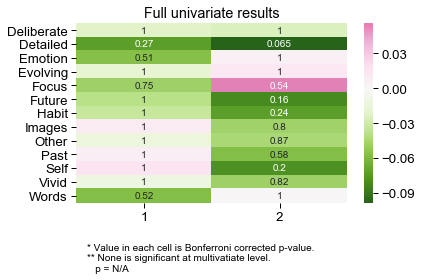

In [13]:
df_stats = pd.concat([df_es_byday[dict_days['2']], df_cca], axis=1, join='inner')
df_stats.columns = lables_es + ['component_1', 'component_2']
df_stats = df_stats.dropna()
print(df_stats.shape)

es2_coef = MANOVA_with_fig(df_stats, lables_es)

## MANOVA: day 3

(143, 15)
                  Multivariate linear model
                                                              
--------------------------------------------------------------
           x0           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9157 13.0000 129.0000  0.9132 0.5414
         Pillai's trace 0.0843 13.0000 129.0000  0.9132 0.5414
 Hotelling-Lawley trace 0.0920 13.0000 129.0000  0.9132 0.5414
    Roy's greatest root 0.0920 13.0000 129.0000  0.9132 0.5414
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
           x1           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.7719 13.0000 129.0000  2.9316 0.0009
         Pillai's trace 0.2281 13.0000 129.0000  2.9316 0.0009
 

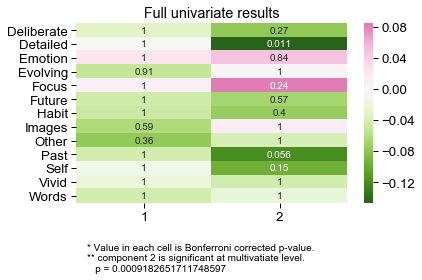

In [14]:
df_stats = pd.concat([df_es_byday[dict_days['3']], df_cca], axis=1, join='inner')
df_stats.columns = lables_es + ['component_1', 'component_2']
df_stats = df_stats.dropna()
print(df_stats.shape)
es3_coef = MANOVA_with_fig(df_stats, lables_es)

0.1


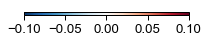

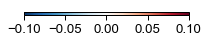

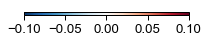

In [15]:
import matplotlib.colors as mcolor
import matplotlib.colorbar as mcb
import matplotlib.cm as mcm

# create colorbar and color
vmax = 0.1
vmin = -vmax

print(vmax)

day = 0
for df in [es1_coef, es2_coef, es3_coef]:
    day += 1
    pv_in_hex= []
    for i in range(df.values.shape[1]):
        rescale = (df.values[:,i] - vmin) / (vmax - vmin)
        colors_hex = []
        for c in mcm.RdBu_r(rescale):
            colors_hex.append(mcolor.to_hex(c))
        pv_in_hex.append(colors_hex)
    colors_hex = np.array(pv_in_hex).T
    df_color = pd.DataFrame(colors_hex, columns=df.columns, index=df.index)

    fig = plt.figure(figsize=(3, 0.7))
    ax = fig.add_subplot(111)
    cmap = mcm.RdBu_r
    norm = mcolor.Normalize(vmin=vmin, vmax=vmax)
    cb1 = mcb.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
    plt.tight_layout()
    # plt.savefig('reports/figures/univariate_es_wordcloud_cb.png', transparent=True, dpi=300)

    df = pd.concat([df['2'], df_color['2']], axis=1)
    df.reset_index(level=0, inplace=True)
    df.columns = ['word', 'ori_weight', 'color']
    df['weight'] = np.round(np.abs(df['ori_weight'] * 100))
    df = df[['weight', 'word', 'color']]
    df.to_csv('reports/figures/stats_wordclouds/univariate_es_wordcloud_day{}.csv'.format(day))

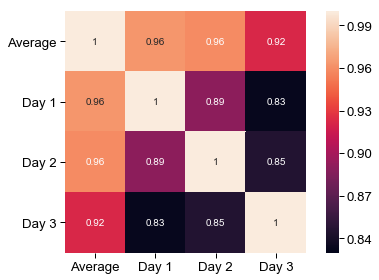

In [22]:
corr_pattern = np.corrcoef([es_coef['2'], es1_coef['2'], es2_coef['2'],es3_coef['2']])
df_cor = pd.DataFrame(corr_pattern,
                      columns=['Average', 'Day 1', 'Day 2', 'Day 3'],
                      index=['Average', 'Day 1', 'Day 2', 'Day 3'])

plt.figure()
sns.heatmap(df_cor, square=True, vmin=0.83, annot=df_cor)
plt.yticks(rotation=0) 
plt.tight_layout()
plt.savefig('reports/figures/stats_wordclouds/pattern_corr.png', dpi=300, transparent=True)

In [23]:
from scipy.stats import pearsonr

print(pearsonr(es_coef['2'], es1_coef['2']))
print(pearsonr(es_coef['2'], es2_coef['2']))
print(pearsonr(es_coef['2'], es3_coef['2']))
print(pearsonr(es2_coef['2'], es1_coef['2']))
print(pearsonr(es3_coef['2'], es1_coef['2']))
print(pearsonr(es3_coef['2'], es2_coef['2']))

(0.9632991332741433, 1.2653446667441699e-07)
(0.9594505451724687, 2.1735835822974708e-07)
(0.9221253537666109, 7.3173423853817985e-06)
(0.8899890692245855, 4.5920103392328045e-05)
(0.8329718389062157, 0.0004070558083350098)
(0.8459133870988568, 0.00026817634866734783)
